In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import glob
import librosa
import numpy as np

from torchsummary import summary

In [2]:
class AudioDataset(Dataset):
    def __init__(self, path, transform=None, sample_rate=16000):
        self.path = path
        self.data_list = glob.glob(self.path + '/*.wav')
        
        self.transform = transform
        self.sr = sample_rate
        self.frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
        self.frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)
        
        self.max = 47.9783
        self.min = 0
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data_path = self.data_list[idx]
        data = self.normalize(self.Mel_S(data_path))
        data = np.expand_dims(data, axis=0)
        
        if self.transform is not None:
            data = self.transform(data)
        
        return data # (1, 40, 80)
    
    def Mel_S(self, wav_file):
        y, sr = librosa.load(wav_file, sr=self.sr)
    
        input_nfft = int(round(sr*self.frame_length))
        input_stride = int(round(sr*self.frame_stride))

        s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
#         print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
        
        return s
    
    def normalize(self, s):
#         s = (s - s.mean()) / s.std() # standardization
#         s = (s - s.min()) / (s.max() - s.min()) # min max normalization
        s = (s - self.min) / (self.max - self.min)
        
        return s

In [3]:
dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

dataset.__len__()
dataset_indices = list(range(dataset.__len__()))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset.__len__()))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=dataset, batch_size=100, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(dataset=dataset, batch_size=100, sampler=val_sampler, shuffle=False)

In [4]:
# data_max = 0
# data_min = 100
# for data in train_loader:
#     if data.max() > data_max:
#         data_max = data.max()
#     if data.min() < data_min:
#         data_min = data.min()
# data_max, data_min

In [5]:
class AE(nn.Module):
    def __init__(self, input_channel=1, h_dim=128*5*10, z_dim=512):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
    
    def get_codes(self, x):
        return self.encoder(x)

ae = AE()
if torch.cuda.is_available():
    ae.cuda()

In [6]:
ae

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [7]:
summary(ae, (1, 40, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 80]             320
              ReLU-2           [-1, 32, 40, 80]               0
         MaxPool2d-3           [-1, 32, 20, 40]               0
            Conv2d-4           [-1, 64, 20, 40]          18,496
              ReLU-5           [-1, 64, 20, 40]               0
         MaxPool2d-6           [-1, 64, 10, 20]               0
            Conv2d-7          [-1, 128, 10, 20]          73,856
              ReLU-8          [-1, 128, 10, 20]               0
         MaxPool2d-9           [-1, 128, 5, 10]               0
  ConvTranspose2d-10           [-1, 64, 10, 20]         131,136
             ReLU-11           [-1, 64, 10, 20]               0
  ConvTranspose2d-12           [-1, 32, 20, 40]          32,800
             ReLU-13           [-1, 32, 20, 40]               0
  ConvTranspose2d-14            [-1, 1,

In [8]:
def train(model, loss, optimizer, num_epochs, early_stopping=False):
    train_loss_arr = []
    test_loss_arr = []
    
    best_test_loss = 9999999999
    early_stop, early_stop_max = 0, 3
    
    for epoch in range(num_epochs):
        
        epoch_loss = 0.
        for batch_idx, data in enumerate(train_loader):
            data = data.cuda()
            optimizer.zero_grad()
            
            model.train()
            outputs = model(data)
            train_loss = loss(outputs, data)
            epoch_loss += train_loss.data
            
            train_loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print(f'Epoch : {epoch} [{batch_idx * len(data)}/{len(train_idx)} ({100. * batch_idx / len(train_idx) :.2f}%)]\
                \tLoss : {train_loss.data / len(data) :.8f}')
        
        train_loss_arr.append((epoch_loss / len(train_idx)).cpu())
        
        # validation
        model.eval()
        
        test_loss = 0.

        for data in val_loader:
            data = data.cuda()

            outputs = model(data)
            batch_loss = loss(outputs, data)
            test_loss += batch_loss.data

        test_loss_arr.append((test_loss / len(val_idx)).cpu())

        if early_stopping:
            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
                print(f'Epoch [{epoch}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')
            else:
                early_stop += 1
                print(f'Epoch [{epoch}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, '+\
                f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')

            if early_stop >= early_stop_max:
                break
        else:
            print(f'Epoch [{epoch}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, ' +\
            f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')

    return train_loss_arr, test_loss_arr

In [9]:
ae_loss = nn.MSELoss()

ae_optimizer = optim.Adam(ae.parameters())

avg_train_loss, avg_test_loss = train(ae, ae_loss, ae_optimizer, 1, early_stopping=True)

Epoch : 0 [0/2316 (0.00%)]                	Loss : 0.00209646
Epoch : 0 [1000/2316 (0.43%)]                	Loss : 0.00007272
Epoch : 0 [2000/2316 (0.86%)]                	Loss : 0.00004314
Epoch [0/1], Average Train Loss : 0.00050656, Average Test Loss : 0.00003284



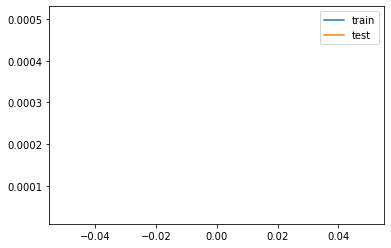

In [10]:
import matplotlib.pyplot as plt
plt.plot(avg_train_loss, label='train')
plt.plot(avg_test_loss, label='test')
plt.legend()

In [11]:
normal_dataset = AudioDataset(path='data/원천데이터/normal_1s')
abnormal_dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

normal_loader = DataLoader(dataset=normal_dataset, batch_size=1, shuffle=False)
abnormal_loader = DataLoader(dataset=abnormal_dataset, batch_size=1, shuffle=False)

In [12]:
mse = nn.MSELoss()

normal_loss = []
ae.eval()
for idx, normal_data in enumerate(normal_loader):
    normal_data = normal_data.cuda()
    output = ae(normal_data)
    loss = mse(normal_data, output)
    normal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / normal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

--2.96%--5.93%--8.89%--11.85%--14.81%--17.78%--20.74%--23.70%--26.67%--29.63%--32.59%--35.56%--38.52%--41.48%--44.44%--47.41%--50.37%--53.33%--56.30%--59.26%--62.22%--65.19%--68.15%--71.11%--74.07%--77.04%--80.00%--82.96%--85.93%--88.89%--91.85%--94.81%--97.78%--100% 
 done


In [13]:
abnormal_loss = []
ae.eval()
for idx, abnormal_data in enumerate(abnormal_loader):
    abnormal_data = abnormal_data.cuda()
    output = ae(abnormal_data)
    loss = mse(abnormal_data, output)
    abnormal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / abnormal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

--3.46%--6.91%--10.37%--13.82%--17.28%--20.73%--24.19%--27.64%--31.10%--34.55%--38.01%--41.47%--44.92%--48.38%--51.83%--55.29%--58.74%--62.20%--65.65%--69.11%--72.56%--76.02%--79.47%--82.93%--86.39%--89.84%--93.30%--96.75%--100% 
 done


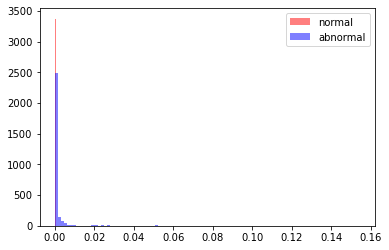

In [14]:
import matplotlib.pyplot as plt


plt.hist(normal_loss, color='r', alpha=0.5, bins=1, label='normal')
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=100, label='abnormal')
plt.legend()

plt.show()

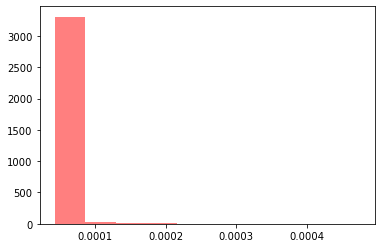

In [15]:
plt.hist(normal_loss, color='r', alpha=0.5, bins=10, label='normal')
plt.show()

In [16]:
len(normal_loss), len(abnormal_loss)

(3375, 2894)

In [17]:
normal_loss = np.array(normal_loss)
len(normal_loss), sum(normal_loss > 0.0001)

(3375, 57)

In [18]:
abnormal_loss = np.array(abnormal_loss)
len(abnormal_loss), sum(abnormal_loss > 0.0001)

(2894, 1326)

Wav lenght : 1.0, Mes_S shape : (40, 80)


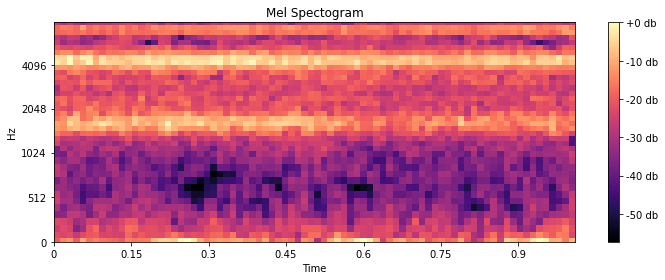

In [19]:
import librosa
import librosa.display

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def Mel_S(wav_file):
    y, sr = librosa.load(wav_file, sr=16000)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    S = (S - normal_dataset.min) / (normal_dataset.max - normal_dataset.min) # min max normalization
    print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f db')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()
    
    return S


data_path = 'data/원천데이터/abnormal_1s/가스사고_511106_label_0.wav'
mel_spec = Mel_S(data_path)

In [20]:
input_x = torch.Tensor(mel_spec.reshape(1,1,40,80)).cuda()
output = ae(input_x)
output.shape

torch.Size([1, 1, 40, 80])

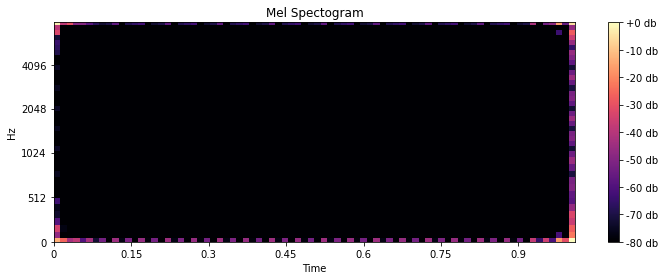

In [21]:
sr = 16000
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(output.cpu().detach().numpy().squeeze(), ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
plt.colorbar(format='%+2.0f db')
plt.title('Mel Spectogram')
plt.tight_layout()
plt.show()

In [22]:
mse = nn.MSELoss()

loss = mse(torch.Tensor(mel_spec).cuda(), output.squeeze())
loss.item() > 0.0001

False

In [23]:
a = mel_spec
b = output.cpu().detach().numpy().squeeze()

In [24]:
sum(sum((a-b)**2)) / (40 * 80), loss.item()

(4.662067726504419e-05, 4.662067658500746e-05)

In [25]:
mel_spec.max()

5.3360833e-05

Wav lenght : 1.0, Mes_S shape : (40, 80)


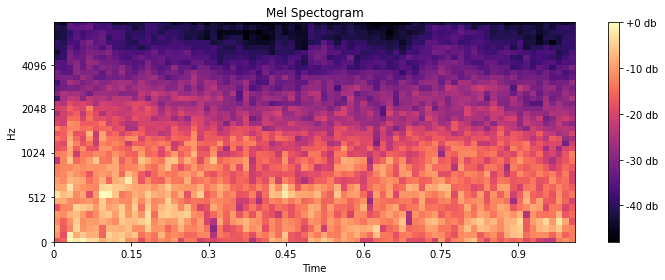

In [31]:
import librosa
import librosa.display

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def Mel_S(wav_file):
    y, sr = librosa.load(wav_file, sr=16000)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    S = (S - normal_dataset.min) / (normal_dataset.max - normal_dataset.min) # min max normalization
    print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f db')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()
    
    return S


data_path = 'data/원천데이터/normal_1s/실내_673584_label_0.wav'
mel_spec = Mel_S(data_path)

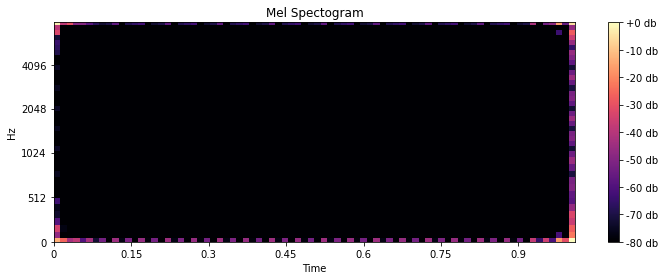

In [32]:
input_x = torch.Tensor(mel_spec.reshape(1,1,40,80)).cuda()
output = ae(input_x)

sr = 16000
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(output.cpu().detach().numpy().squeeze(), ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
plt.colorbar(format='%+2.0f db')
plt.title('Mel Spectogram')
plt.tight_layout()
plt.show()

Wav lenght : 1.0, Mes_S shape : (40, 80)


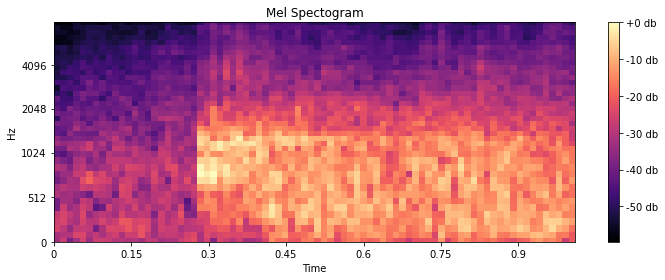

In [33]:
import librosa
import librosa.display

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def Mel_S(wav_file):
    y, sr = librosa.load(wav_file, sr=16000)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    S = (S - normal_dataset.min) / (normal_dataset.max - normal_dataset.min) # min max normalization
    print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f db')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()
    
    return S


data_path = 'data/원천데이터/normal_1s/실내_673584_label_3.wav'
mel_spec = Mel_S(data_path)

In [34]:
import soundfile as sf

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def mel_to_audio(mel, sr=16000):
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    return librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=input_nfft, hop_length=input_stride)
    
audio = mel_to_audio(mel_spec)
sf.write("mel_to_wav_test.wav", audio, 16000)

In [35]:
test_x = mel_spec.reshape(1,1,40,80)
test_x = torch.Tensor(test_x).cuda()

In [36]:
output = ae(test_x).reshape(40,80)
output.shape

torch.Size([40, 80])

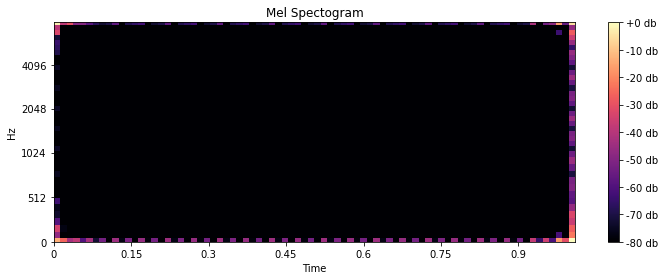

In [37]:
sr = 16000
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(output.cpu().detach().numpy(), ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
plt.colorbar(format='%+2.0f db')
plt.title('Mel Spectogram')
plt.tight_layout()
plt.show()

In [38]:
audio2 = mel_to_audio(output.cpu().detach().numpy())
sf.write("ae_output.wav", audio2, 16000)

Wav lenght : 1.0, Mes_S shape : (40, 80)


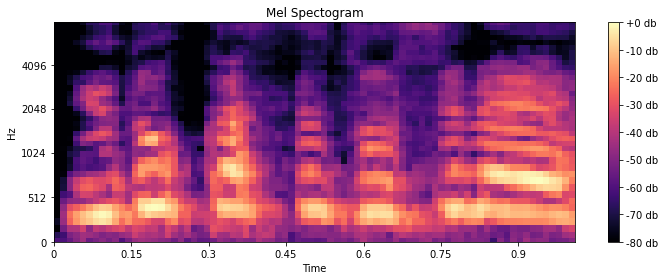

In [39]:
import librosa
import librosa.display

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def Mel_S(wav_file):
    y, sr = librosa.load(wav_file, sr=16000)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    S = (S - normal_dataset.min) / (normal_dataset.max - normal_dataset.min) # min max normalization
    print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f db')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()
    
    return S


data_path = 'data/원천데이터/abnormal_1s/가스사고_550795_label_0.wav'
mel_spec = Mel_S(data_path)

In [40]:
import soundfile as sf

frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)

def mel_to_audio(mel, sr=16000):
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    return librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=input_nfft, hop_length=input_stride)
    
audio = mel_to_audio(mel_spec)
sf.write("mel_to_wav_test2.wav", audio, 16000)

In [41]:
test_x = mel_spec.reshape(1,1,40,80)
test_x = torch.Tensor(test_x).cuda()

In [42]:
output = ae(test_x).reshape(40,80)
output.shape

torch.Size([40, 80])

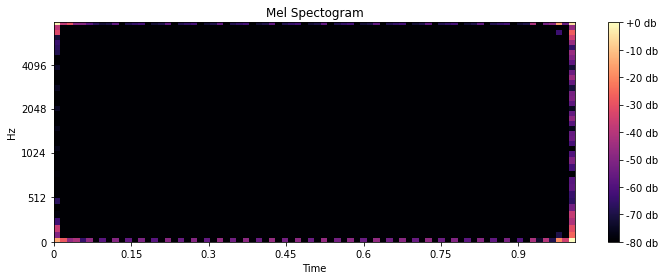

In [43]:
sr = 16000
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(output.cpu().detach().numpy(), ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
plt.colorbar(format='%+2.0f db')
plt.title('Mel Spectogram')
plt.tight_layout()
plt.show()

In [44]:
audio2 = mel_to_audio(output.cpu().detach().numpy())
sf.write("ae_output2.wav", audio2, 16000)

In [85]:
type(mel_spec), output.shape

(numpy.ndarray, torch.Size([40, 80]))

In [88]:
mse = nn.MSELoss()
mse(torch.Tensor(mel_spec).cuda(), output)

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)

In [97]:
mse = nn.MSELoss()
mse(torch.Tensor(mel_spec).cuda(), output)

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
import librosa
import librosa.display
import soundfile as sf

data_path = ""
raw_file_name = ""
ae_file_name = ""


frame_length = 0.025 # win_length, 자연어 처리 분야에서 25ms 크기를 기본으로 하고 있음 (16000Hz -> 400)
frame_stride = 0.0126 # hop_length, 일반적으로 10ms의 크기를 기본으로 하고 있음 (16000Hz -> 160)
sr = 16000
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))

def Mel_S(wav_file):
    y, sr = librosa.load(wav_file, sr=16000)   
    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    S = (S - S.mean()) / S.std() # standardization
    S = (S - S.min()) / (S.max() - S.min()) # min max normalization
    print(f"Wav lenght : {len(y)/sr}, Mes_S shape : {np.shape(S)}")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f db')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()
    
    return S

data_path = 'data/원천데이터/abnormal_1s/가스사고_550795_label_0.wav'
mel_spec = Mel_S(data_path)


def mel_to_audio(mel, sr=16000):
    return librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=input_nfft, hop_length=input_stride)
    
audio = mel_to_audio(mel_spec)
sf.write(f"{raw}.wav", audio, 16000)

test_x = mel_spec.reshape(1,1,40,80)
test_x = torch.Tensor(test_x).cuda()
output = ae(test_x).reshape(40,80)
output.shape

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(output.cpu().detach().numpy(), ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
plt.colorbar(format='%+2.0f db')
plt.title('Mel Spectogram')
plt.tight_layout()
plt.show()

audio2 = mel_to_audio(output.cpu().detach().numpy())
sf.write(f"{ae}.wav", audio2, 16000)